# Extended SONIC model - validation of custom connection scheme

## Rationale

### Objective
Create a custom implementation of the *NEURON **connect*** function to connect 2 sections together that:
- Allows to specify any reference voltage variable to compute axial currents
- Works on a simple multi-compartmental model with multiple nodes connected in series (no branching)
- Yields accurate results
- Does not significantly hinder numerical integration

### Theory of axial conduction
Let's consider the properties of a cylindrical section of diameter $d$, length $L$ and axial resistivity $R_a$ (in $\Omega \cdot cm$):
- Axial (i.e. cross-sectional) surface area: $A_x = \pi D^2 / 4$
- Longitudinal (i.e. membrane) surface area: $A_m = \pi D L$
- Axial resistance: $R = \frac{R_a L}{A_x}$  (in $\Omega$)

The axial current flowing between the centers of two adjacent sections of resistances $R_1, R_2$ (in $\Omega$) and voltages $V_1, V_2$ (in $mV$), respectively, is: 
$I_{ax, 1-2} = \frac{V_2 - V_1}{R_1 / 2 + R_2 / 2}$ (in mA)

Thus, for a section **k** connected in series with **k-1** and **k+1** compartments, the total axial current flowing in the section is: 
$I_{ax, k} = 2 \big(\frac{V_k - V_{k-1}}{R_k + R_{k-1}} + \frac{V_k - V_{k+1}}{R_k + R_{k+1}}\big)$ (in mA)

For a simple model consisting of multiple connected nodes with equal diameter $D$, length $L$ and cytoplasmic resistivity $R_a$, we have: 
$i_{ax, k} = \frac{1}{A_m} I_{ax, k} = \frac{1}{A_m} \frac{A_x}{R_a L} (2 V_k - V_{k-1} - V_{k+1}) \propto \frac{A_x}{A_m R_a L} = \frac{\pi D^2 / 4}{\pi D L R_a L} = \frac{D / 4}{R_a L^2}$

Thus axial current density is proportional to $D$, $1/R_a$ and $1/L^2$.

### Problem
If we connect adjacent section using the standard *NEURON* **connect** function, the contribution of axial currents to the evolution of distributed membrane potentials is computed implicitly using $v$ as the reference voltage variable.

### Solution
Implement axial current as a distributed membrane mechanism that computes a current density similarly to other membrane currents: 
$i_{ax, k} = \frac{I_{ax, k}}{A_m}$  (in $mA/cm^2$)
- axial resistances of previous, current and next sections are provided to the mechanism as static RANGE parameters
- membrane potentials of previous, current and next sections are provided to the mechanism as POINTER variables, pointing to the reference voltage variable of choice, in order to be dynamically updated throughout the simulation

### Implementation
To implement our custom connection scheme, a ***SeriesConnector*** object is defined.

It contains the following attributes:
- ***mechname***: the name of the custom density mechanism that computes axial current
- ***vref***: the name of the reference voltage variable to compute axial currents

And the following methods:
- ***attach***: inserts a specific axial current density mechanism into a section and set appropriate axial conduction parameters
- ***connect***: connects two adjacent sections in series, by setting appropriate PARAMETER and POINTER variables to create a bi-directional link


## Validation
Let's validate our custom implementation against the classic ***connect*** function, by comparing the generation and propagation of action potentials upon electrical stimulation.

### Imports
Let's import the necessary packages and modules

In [1]:
import time
import logging
import numpy as np
import matplotlib.pyplot as plt

from PySONIC.utils import logger
from PySONIC.neurons import CorticalRS
from ext_sonic import SeriesConnector
from run_utils import compareEStim

logger.setLevel(logging.DEBUG)

### Parameters
Let's set some default model and stimulation parameters.

By default, we will use an adaptive time step (CVODE) method, as we will see later that this method is far better than the fixed time step method to ensure convergence (sometimes at the expense of computation speed).

In [2]:
# Model parameters
neuron = CorticalRS()
nnodes = 3
Ra = 1e2  # default order of magnitude found in litterature (Ohm.cm)
diam = 1e-6  # order of magnitude of axon node diameter (m)
L = 1e-5  # between order of magnitude of axon node length (1 um) and internode length (100um - 1 mm)

# Stimulation parameters
tstim = 150e-3  # s
toffset = 100e-3  # s
PRF = 100.  # Hz
DC = 1.
Astim = 30.0  # mA/m2

### SeriesConnector object
Let's build a ***SeriesConnector*** object based on the *Iax* density mechanism and using the NEURON's default variable ***v*** as its reference voltage variable:

In [3]:
# SeriesConnector object to connect sections in series through custom implementation
connector = SeriesConnector(mechname='Iax', vref='v', rmin=None, verbose=True)
print(connector)

Series connector object: Iax density mechanism, reference voltage variable = "v"


## Default conditions

 22/08/2018 01:42:40: Creating model: NBLS_RS_3nodes (diam = 1 um, L = 10 um, Ra = 1e+02 ohm.cm) - classic connect scheme
 22/08/2018 01:42:40: Simulation completed in 11.03 ms
 22/08/2018 01:42:40: Creating model: NBLS_RS_3nodes (diam = 1 um, L = 10 um, Ra = 1e+02 ohm.cm) - custom connect scheme
 22/08/2018 01:42:46: Simulation completed in 5405.92 ms


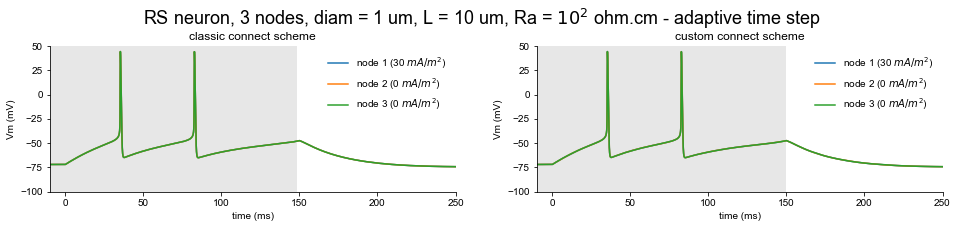

In [4]:
fig = compareEStim(neuron, nnodes, diam, L, Ra, connector, Astim, tstim, toffset, PRF, DC)

Expectedly, in these default conditions, the small node length limits axial axial resistance, therefore axial currents allow total "synchronization" of nodes, and distributed membrane potential profiles are identical.

Both solutions look identical. However, the custom implementation yields significantly slower computation times than the classic one (more than 2 orders of magnitude slower !!!).

### Restricting axial conduction

It seems that our custom connection scheme generates axial current densities of strong magnitude, thereby increasing the system stiffness and forcing the CVODE solver to drastically reduce time step size to ensure convergence.

Let's try to limit the magnitude of axial current density $i_{ax, k} = \frac{\Delta V}{R \cdot A_m}$ by setting a lower bound for $R \cdot A_m$.

After a quick manual search, we find $10^2$ $\Omega \cdot cm^2$ as the optimal lower bound:

In [5]:
connector.rmin = 1e2  # Set minimal "resistance density" in custom axial current mechanism 
print(connector)

Series connector object: Iax density mechanism, reference voltage variable = "v", minimal resistance density = 1.00e+02 Ohm.cm2


Let's check the consequences of that change:

 22/08/2018 01:42:47: Creating model: NBLS_RS_3nodes (diam = 1 um, L = 10 um, Ra = 1e+02 ohm.cm) - classic connect scheme
 22/08/2018 01:42:47: Simulation completed in 10.53 ms


R*Am = 4.00e+00 Ohm.cm2 -> bounded to 1.00e+02 Ohm.cm2
R*Am = 4.00e+00 Ohm.cm2 -> bounded to 1.00e+02 Ohm.cm2
R*Am = 4.00e+00 Ohm.cm2 -> bounded to 1.00e+02 Ohm.cm2


 22/08/2018 01:42:47: Creating model: NBLS_RS_3nodes (diam = 1 um, L = 10 um, Ra = 1e+02 ohm.cm) - custom connect scheme
 22/08/2018 01:42:47: Simulation completed in 221.62 ms


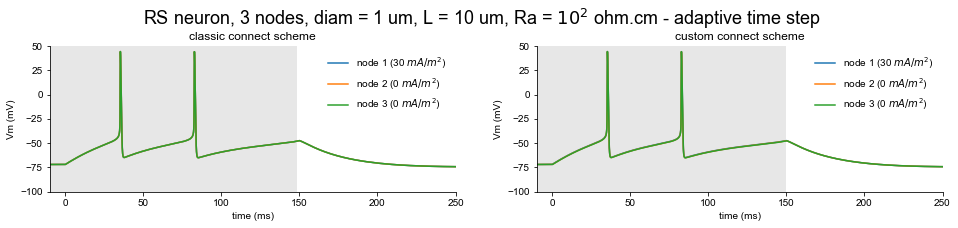

In [6]:
fig = compareEStim(neuron, nnodes, diam, L, Ra, connector, Astim, tstim, toffset, PRF, DC)

As we can see, axial resistance density here is increased by a factor *100*.

As a result, computation time is drastically reduced, while solution convergence and accuracy is conserved.

## Robustness to changes in parameters

Let's now test the robustness of our implementation to various changes in model and stimulation parameters.

In [7]:
logger.setLevel(logging.INFO)
connector.verbose = False

### Node diameter

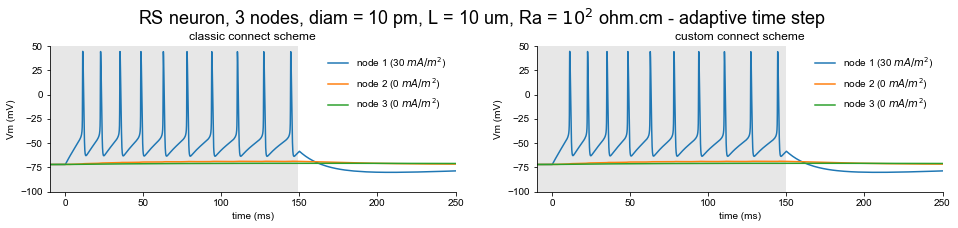

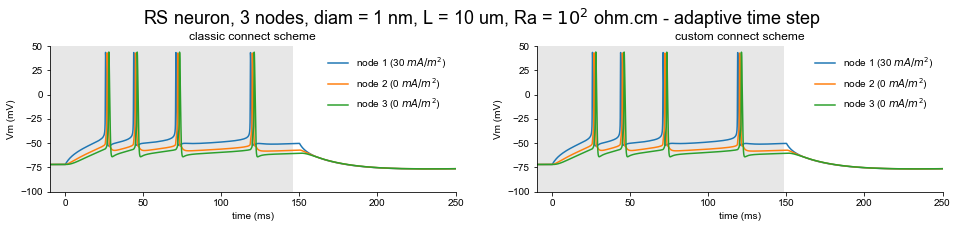

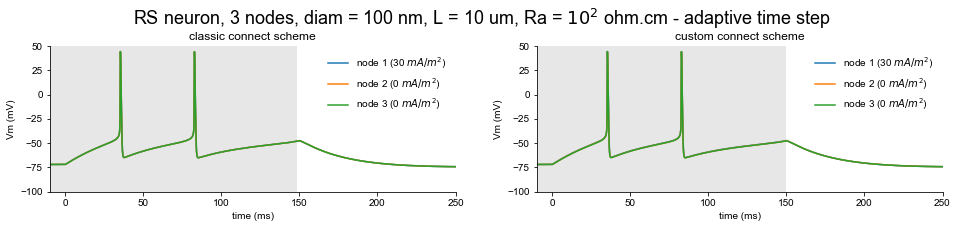

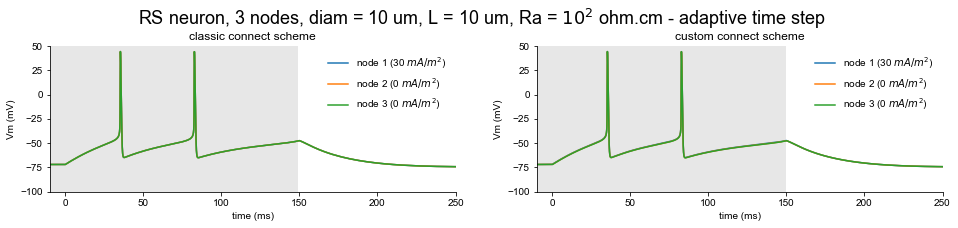

In [8]:
for diam_range in np.logspace(-11, -5, 4):
    fig = compareEStim(neuron, nnodes, diam_range, L, Ra, connector, Astim, tstim, toffset, PRF, DC)

Our implementation seems robust to change in $D$:
- For very small node diameters, the huge axial resistance limits axial currents, which prevents action potentials from spreading from the stimulated node.
- As node diameter increases, reduced axial resistance allows action potentials to spread to neighboring nodes, but with an intrinsic delay that increases with distance.
- For large node diameters, very small axial resistance allows prefect "synchronization" between all nodes.

### Node length

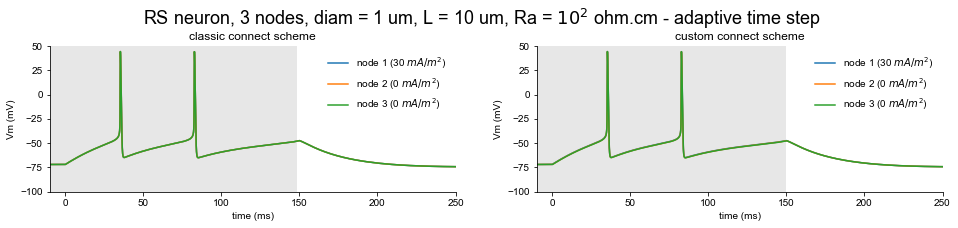

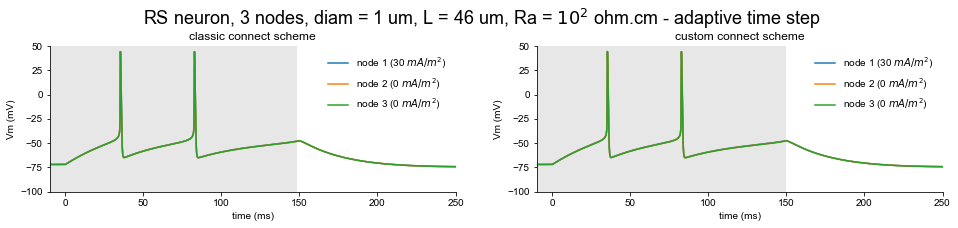

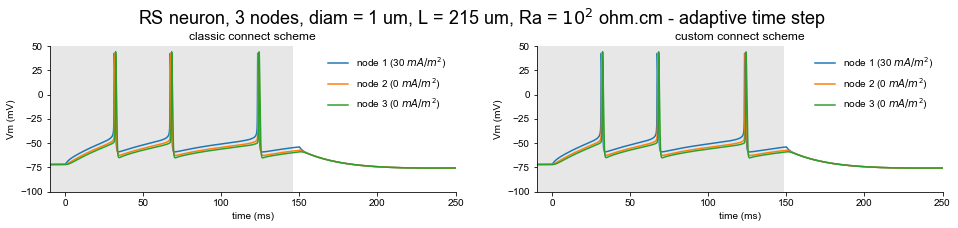

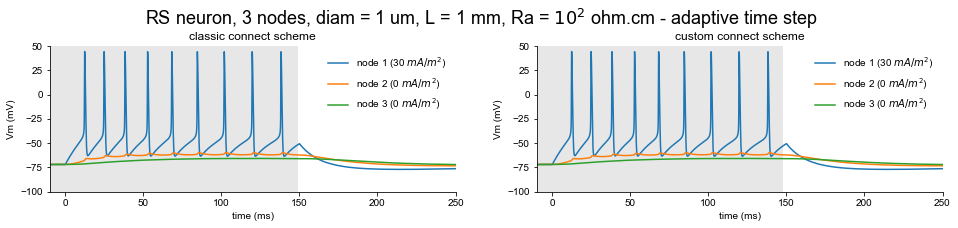

In [9]:
for L_range in np.logspace(-5, -3, 4):
    fig = compareEStim(neuron, nnodes, diam, L_range, Ra, connector, Astim, tstim, toffset, PRF, DC)

Our implementation seems also robust to changes in $L$.

The effect is exactly the opposite as for $D$: increasing node length augments axial resistance and thereby reduces cross-node synchronization.

### Cytoplasmic resistivity

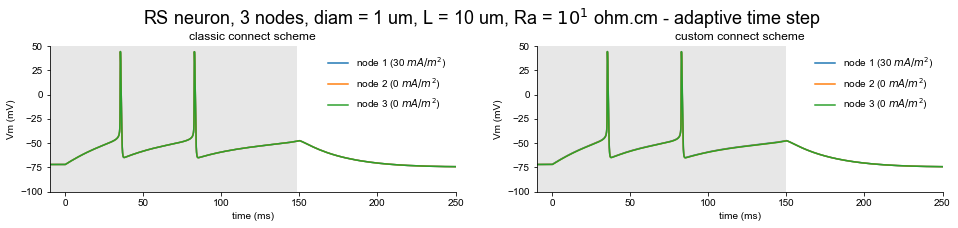

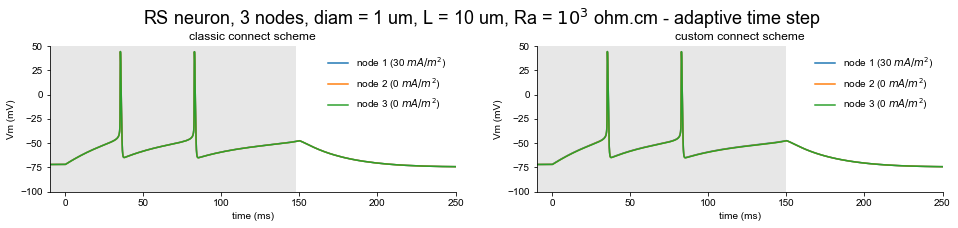

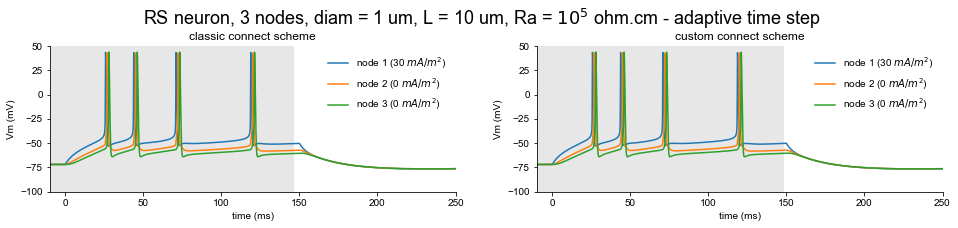

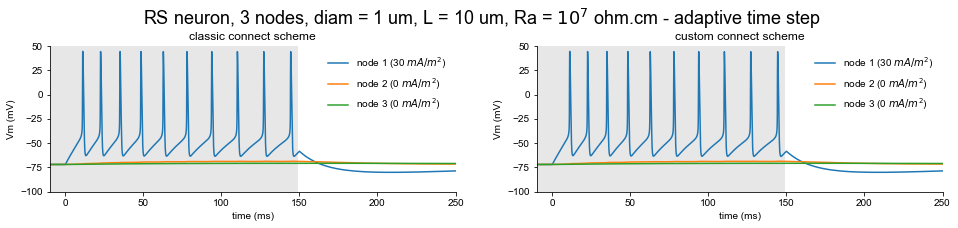

In [10]:
for Ra_range in np.logspace(1, 7, 4):
    fig = compareEStim(neuron, nnodes, diam, L, Ra_range, connector, Astim, tstim, toffset, PRF, DC)

Our implementation seems also robust to changes in $R_a$.

The effect is similar to that of $L$: increasing cytoplasmic resistivity augments axial resistance and thereby reduces cross-node synchronization.

### Number of nodes

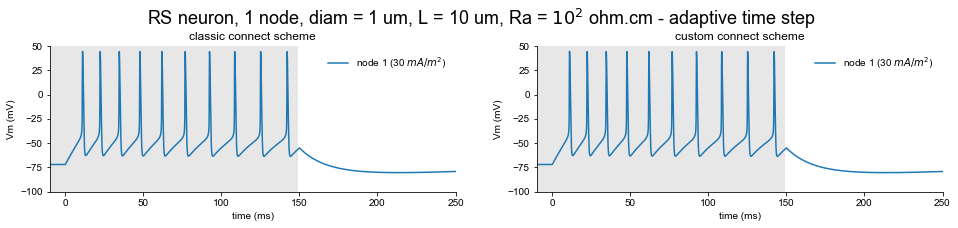

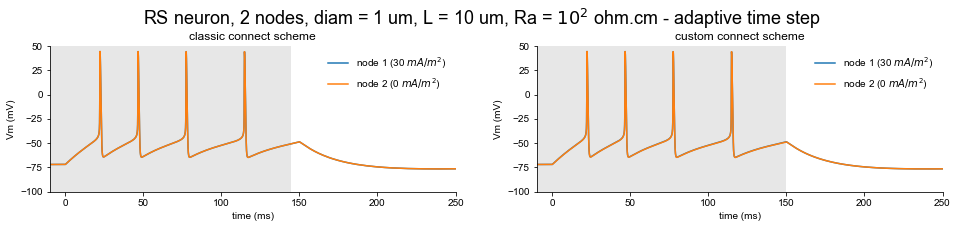

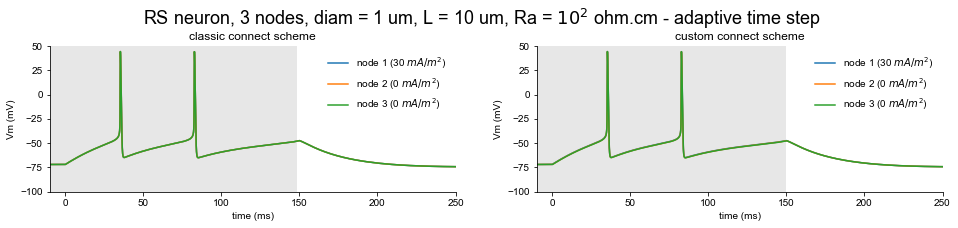

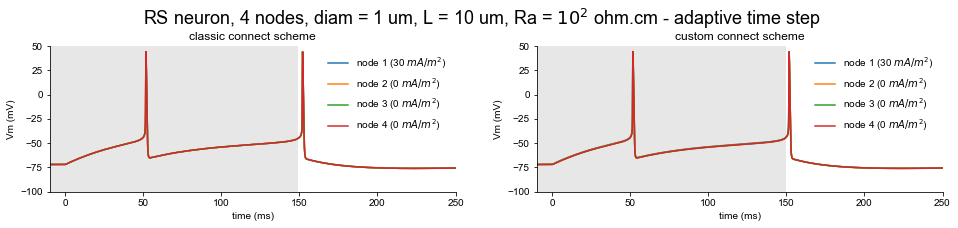

In [11]:
for nnodes_range in range(1, 4 + 1):
    fig = compareEStim(neuron, nnodes_range, diam, L, Ra, connector, Astim, tstim, toffset, PRF, DC)

Our implementation is also robust to changes in $n_{nodes}$.

Increasing the number of nodes creates a higher axial driving force at the stimulated node: axial currents spread more intensely towards neighboring nodes, thereby limiting the depolarization of the stimulated node. As a result, less action potentials are fired, but they're all conducted through all nodes. 

### Stimulus amplitude

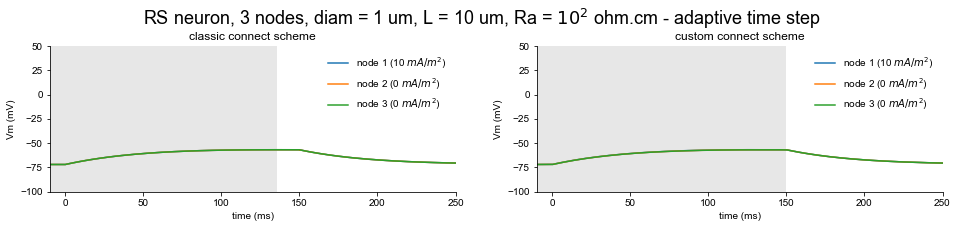

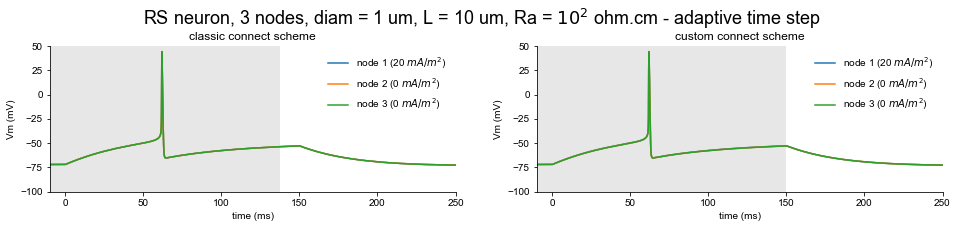

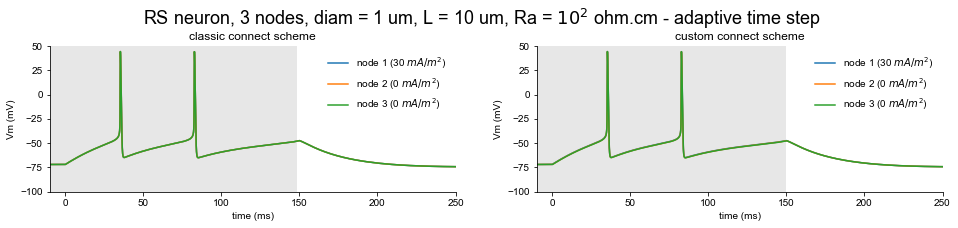

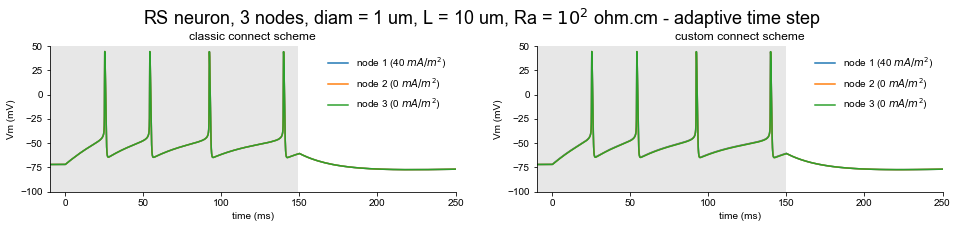

In [12]:
for Astim_range in np.linspace(10, 40, 4):
    fig = compareEStim(neuron, nnodes, diam, L, Ra, connector, Astim_range, tstim, toffset, PRF, DC)

Our implementation is robust to changes in $A_{stim}$.

Expectedly, increasing the magnitude of depolarizing current accelerates membrane depolarization, hence the neuron fires more action potentials.

### Stimulus duty cycle

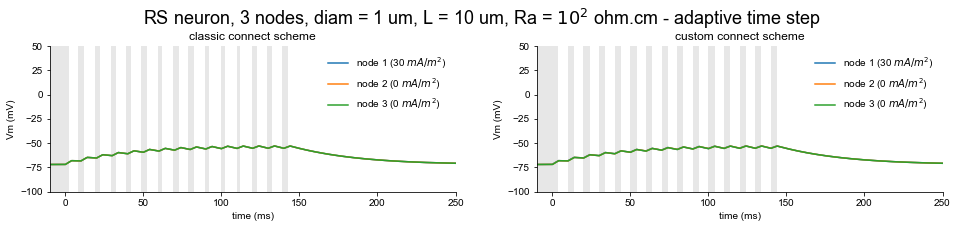

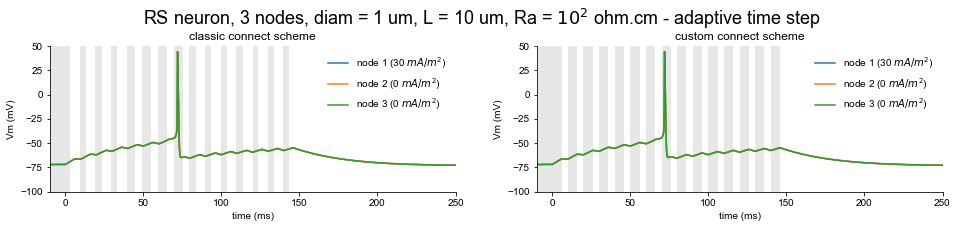

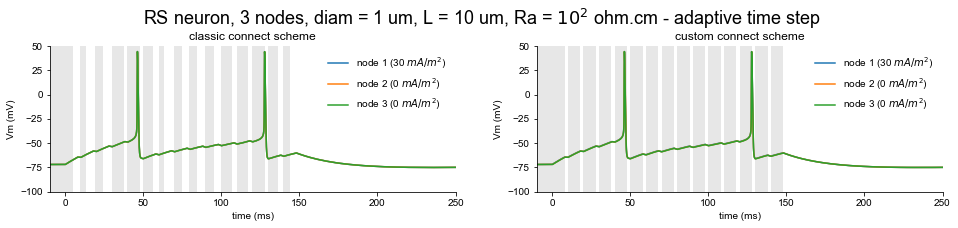

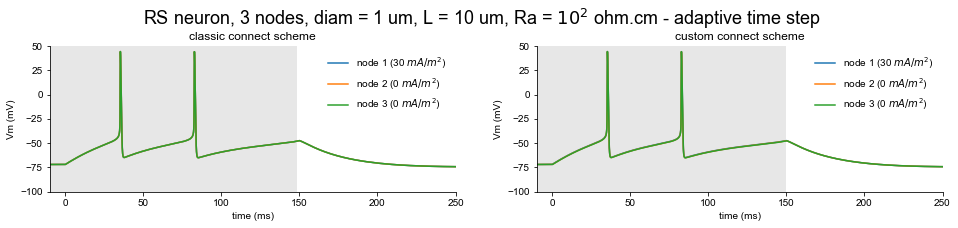

In [13]:
for DC_range in np.linspace(0.4, 1, 4):
    fig = compareEStim(neuron, nnodes, diam, L, Ra, connector, Astim, tstim, toffset, PRF, DC_range)

Our implementation is robust to changes in $DC$.

Expectedly, increasing the stimulus duty cycle accelerates membrane depolarization, hence the neuron fires more action potentials.

## Integration method

So far, we have used an adaptive time step (CVODE) method to ensure convergence without worrying about temporal resolution.

Let's now compare the efficiency of the that method with the fixed time step integration method.

### Optimal time step for fixed integration

We first need to determine the optimal time step for the fixed integration method.

 22/08/2018 01:43:01: Creating model: NBLS_RS_3nodes (diam = 1 um, L = 10 um, Ra = 1e+02 ohm.cm) - classic connect scheme
 22/08/2018 01:43:04: Simulation completed in 3352.91 ms
 22/08/2018 01:43:05: Creating model: NBLS_RS_3nodes (diam = 1 um, L = 10 um, Ra = 1e+02 ohm.cm) - custom connect scheme
 22/08/2018 01:43:08: Simulation completed in 3448.17 ms
 22/08/2018 01:43:08: Creating model: NBLS_RS_3nodes (diam = 1 um, L = 10 um, Ra = 1e+02 ohm.cm) - classic connect scheme
 22/08/2018 01:43:08: Simulation completed in 332.38 ms
 22/08/2018 01:43:08: Creating model: NBLS_RS_3nodes (diam = 1 um, L = 10 um, Ra = 1e+02 ohm.cm) - custom connect scheme
 22/08/2018 01:43:09: Simulation completed in 342.41 ms
 22/08/2018 01:43:09: Creating model: NBLS_RS_3nodes (diam = 1 um, L = 10 um, Ra = 1e+02 ohm.cm) - classic connect scheme
 22/08/2018 01:43:09: Simulation completed in 36.63 ms
 22/08/2018 01:43:09: Creating model: NBLS_RS_3nodes (diam = 1 um, L = 10 um, Ra = 1e+02 ohm.cm) - custom conne

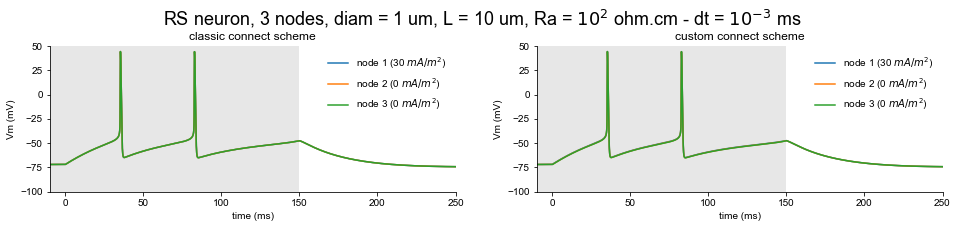

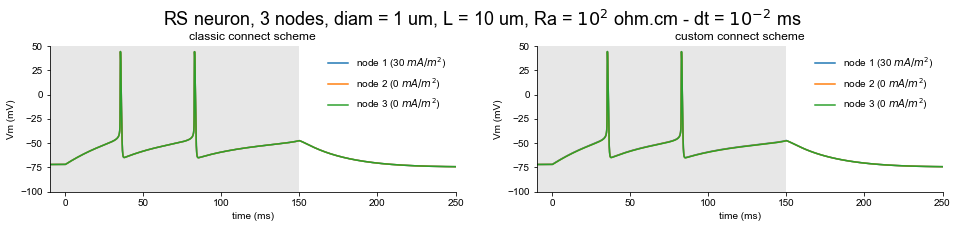

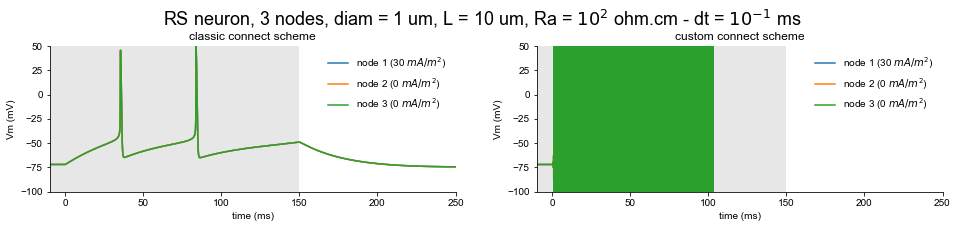

In [14]:
logger.setLevel(logging.DEBUG)
for dt in np.logspace(-6, -4, 3):
    fig = compareEStim(neuron, nnodes, diam, L, Ra, connector, Astim, tstim, toffset, PRF, DC, dt)

- As we can see, a time step of $10^{-3}$ ms ensures convergence but yields a long resolution time.  
- Oppositely, a time step of $10^{-1}$ ms yields a fast simulation but does converge at all.
- A time step of $10^{-2}$ ms seems to yield reasonable simulation time while ensuring convergence. Hence, we select it as our optimal time step.

### Variable vs. Fixed time step

Let's compare computational efficiency and accuracy of both methods.

 22/08/2018 01:43:11: Creating model: NBLS_RS_3nodes (diam = 1 um, L = 10 um, Ra = 1e+02 ohm.cm) - classic connect scheme
 22/08/2018 01:43:11: Simulation completed in 10.53 ms
 22/08/2018 01:43:11: Creating model: NBLS_RS_3nodes (diam = 1 um, L = 10 um, Ra = 1e+02 ohm.cm) - custom connect scheme
 22/08/2018 01:43:11: Simulation completed in 219.08 ms
 22/08/2018 01:43:11: Creating model: NBLS_RS_3nodes (diam = 1 um, L = 10 um, Ra = 1e+02 ohm.cm) - classic connect scheme
 22/08/2018 01:43:12: Simulation completed in 333.39 ms
 22/08/2018 01:43:12: Creating model: NBLS_RS_3nodes (diam = 1 um, L = 10 um, Ra = 1e+02 ohm.cm) - custom connect scheme
 22/08/2018 01:43:12: Simulation completed in 374.49 ms


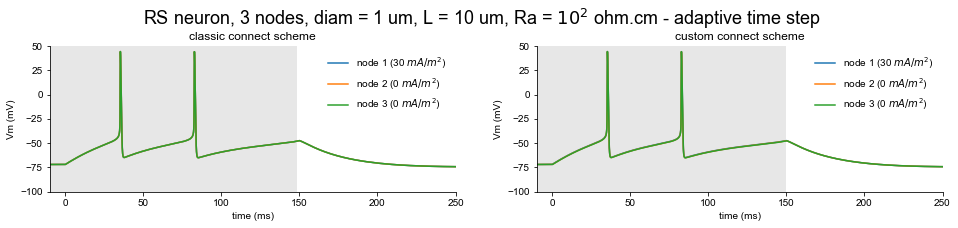

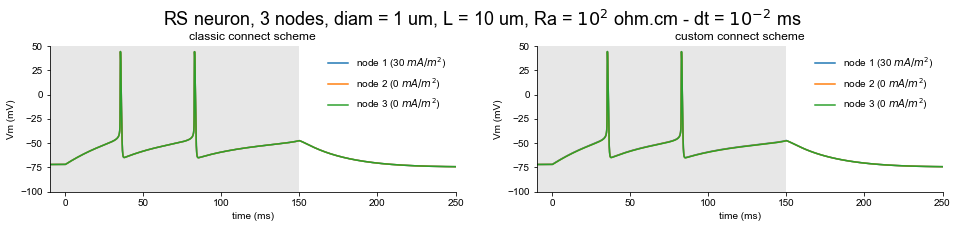

In [15]:
dt_opt = 1e-5  # s
fig = compareEStim(neuron, nnodes, diam, L, Ra, connector, Astim, tstim, toffset, PRF, DC, None)
fig = compareEStim(neuron, nnodes, diam, L, Ra, connector, Astim, tstim, toffset, PRF, DC, dt_opt)

As we can see, the adaptive time step method yields faster resolution times, both with the classic connection scheme and our custom implementation.

We also notice that our implementation still yields longer resolution times than the classic one, but these are to a reasonable order of magnitude.

## Conclusions

- Our custom implementation to connect sections is accurate across all conditions.
- Axial "resistance density" ($R \cdot A_m$) must be lower bounded to limit axial currents magnitude and ensure convergence. That does not seem to affect the accuracy of computed solutions.
- The adaptive time step CVODE solver reduces computation times.
- Resolution time is significantly increased compared to classic implementation but stays reasonable.

Overall, our custom connection scheme seems accurate and reasonably efficient, hence we can adapt to be used for acoustic simulations (using this time $V_{m, eff}$ as the reference voltage variable).